In [1]:
import math
import numpy as np
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr


sys.path.append('../')

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

'0.1.0'

In [49]:
"""Read in gX and fs2 from CSV files."""
def fj2(nj, qLj):
    if qLj==0:
        if nj==1:
            return 1
        else:
            return 0        
    qlp = np.abs(qLj)/np.pi
    # mathsinc(x) = np.sinc(x/pi)
    s_minus = np.sinc(0.5*(qlp - nj + 1))/(1 + (nj-1)/qlp)
    s_plus = np.sinc(0.5*(qlp - nj - 1))/(1 + (nj+1)/qlp)
    return (s_minus - s_plus)**2

# Long thin box limit: assuming that Lz > Lx,Ly, 
# so the lowest excited states are nz=2, nz=3, with nx=ny=1. 

def fs2_nz(Lvec, nz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    (Lx, Ly, Lz) = Lvec
    (qx, qy, qz) = q_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
#     qL = qLx + qLy + qLz
    fx2 = fj2(1, qLx)
    fy2 = fj2(1, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

def DeltaE_nz(nz, Lz):
    # for nx=ny=1 final states, in units of [q**2]/mElec
    return 0.5*math.pi**2 / mElec * (nz**2 - 1)/Lz**2

QMAX = 10*qBohr # Global value for q0=qMax for wavelets

def fs2_model4(qSph):
    (q, theta, phi) = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    return fs2_nz((4/qBohr, 7/qBohr, 10/qBohr), 2, (qx,qy,qz))
fs2_model4.is_gaussian = False
fs2_model4.z_even = True
fs2_model4.phi_even = True
fs2_model4.phi_cyclic = 2
fs2_model4.DeltaE = 4.03*eV

Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)
vegas_params = dict(neval=1e5, nitn_init=5, 
                    neval_init=3e3, nitn=10, verbose=True, 
                    weight_by_vol=True, neval_min=1e3)

# # Read Fnlm from saved csv file...
fs2 = vsdm.ProjectFnlm(Qdict, fs2_model4, vegas_params, 
                       nlmlist=None, f_type='fs2', use_gvar=False)
fs2.importFnlm_csv('demo/fs2_box_4_7_10.csv')
print(fs2.basis)
print(fs2.t_eval)
print('nCoeffs = {}'.format(len(fs2.getNLMlist())))


{'u0': 37289.47137978341, 'type': 'wavelet', 'uMax': 37289.47137978341, 'neval': 100000.0, 'nitn_init': 5, 'neval_init': 3000.0, 'nitn': 10, 'verbose': True, 'weight_by_vol': True, 'neval_min': 1000.0, 'is_gaussian': False}
0.5065240859985352
nCoeffs = 18240


In [3]:
def gaussian_stream_sum(ci, vWsph_i, sigma_i):
    # Arguments: lists of amplitudes gi, dispersions v0_i, and 
    #     lab-frame DM wind vectors vWsph_i, in spherical coordinates
    gvec_list = []
    for i in range(len(gi)):
        gaus = (ci[i], vWsph_i[i], sigma_i[i])
        gvec_list += [gaus]
    return gvec_list 

# Define a function to convert GaussianF(gX) into GaussianF(tilde_gX),
# for dimensionless function tilde_gX = u0**3 * gX,
# where u0 is the vsdm.Basis.u0 scale factor
def gX_to_tgX(gauF, u0):
    tgauF_vecs = gauF.rescaleGaussianF(u0**3)
    return vsdm.GaussianFnlm(gauF.basis, tgauF_vecs)


# Model 4: a bunch of streams, not symmetric. 
# Including the halo component without vEsc.
v0_main = 220*km_s
v0_a = 70*km_s
v0_b = 50*km_s
v0_c = 25*km_s
vX_main = vsdm.cart_to_sph((0, 0, -230*km_s))
vX_a = vsdm.cart_to_sph((80*km_s, 0, -80*km_s))
vX_b = vsdm.cart_to_sph((-120*km_s, -250*km_s, -150*km_s))
vX_c = vsdm.cart_to_sph((50*km_s, 30*km_s, -400*km_s))
sigma_i = [v0_main, v0_a, v0_b, v0_c]
vWsph_i = [vX_main, vX_a, vX_b, vX_c]
gi = [0.4, 0.3, 0.2, 0.1]
gvec_list_4 = gaussian_stream_sum(gi, vWsph_i, sigma_i)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
Vdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)
gXmodel_4 = vsdm.GaussianFnlm(Vdict, gvec_list_4)
gtilde_4 = gX_to_tgX(gXmodel_4, VMAX)
gvec_tilde_4 = gtilde_4.gvec_list

doNumericEvaluation = False
csvname = 'gX_model4'

gvegas_params = dict(neval=1e4, nitn=7, nitn_init=3, 
                     weight_by_vol=True, neval_min=3e2,
                     neval_init=3e2, verbose=False)

"""Read from CSV"""
gX = vsdm.ProjectFnlm(Vdict, gtilde_4, gvegas_params, 
                      nlmlist=None, f_type='gX')
gX.importFnlm_csv('demo/'+csvname+'.csv')
print(gX.basis)
print(gX.t_eval)
print('nCoeffs = {}'.format(len(gX.getNLMlist())))


{'u0': 0.0032022202060095, 'type': 'wavelet', 'uMax': 0.0032022202060095, 'neval': 10000.0, 'nitn': 7, 'nitn_init': 3, 'weight_by_vol': True, 'neval_min': 300.0, 'neval_init': 300.0, 'verbose': False, 'is_gaussian': True}
5.676723003387451
nCoeffs = 262848


## Preparation: Filtered versions of gX and fs2

In [ ]:
t0 = time.time()
"""For understanding precision/convergence in gX and fs2..."""
genergy_for_norm = gX.f2nlm_energy()
fenergy_for_norm = fs2.f2nlm_energy()
print('energy time:', time.time() - t0)

In [11]:
# Sorted
sume = 0.
# conv = []
gNLM_10 = []
gNLM_30 = []
gNLM_100 = []
gNLM_300 = []
for key,value in gX.getNLMpower().items():
    power = value/genergy_for_norm
    sume += power
#     conv += [sume.mean]
    if sume < 0.9:
        gNLM_10 += [key]
    if sume < 0.97:
        gNLM_30 += [key]
    if sume < 0.99:
        gNLM_100 += [key]
    if sume < 0.997:
        gNLM_300 += [key]
    if sume > 0.997:
        break
    
[len(gNLM_10), len(gNLM_30), len(gNLM_100), len(gNLM_300)]

[1430, 3062, 5229, 8483]

In [12]:

# Sorted
sume = 0.
# conv = []
fNLM_10 = []
fNLM_30 = []
fNLM_100 = []
fNLM_300 = []
for key,value in fs2.getNLMpower().items():
    power = value/fenergy_for_norm
    sume += power
#     conv += [sume.mean]
    if sume < 0.9:
        fNLM_10 += [key]
    if sume < 0.97:
        fNLM_30 += [key]
    if sume < 0.99:
        fNLM_100 += [key]
    if sume < 0.997:
        fNLM_300 += [key]
    if sume > 0.997:
        break
    
[len(fNLM_10), len(fNLM_30), len(fNLM_100), len(fNLM_300)]

[222, 610, 1437, 3258]

In [13]:
"""What are ellMax for each pairing..."""
def get_ellMax(nlmlist):
    lmax = 0
    for nlm in nlmlist:
        if nlm[1] > lmax:
            lmax = nlm[1]
    return lmax

ellMax_10 = np.min([get_ellMax(fNLM_10), get_ellMax(gNLM_10)])
ellMax_30 = np.min([get_ellMax(fNLM_30), get_ellMax(gNLM_30)])
ellMax_100 = np.min([get_ellMax(fNLM_100), get_ellMax(gNLM_100)])
ellMax_300 = np.min([get_ellMax(fNLM_300), get_ellMax(gNLM_300)])
print(ellMax_10, ellMax_30, ellMax_100, ellMax_300)



24 32 36 36


In [14]:
gX_10 = vsdm.ProjectFnlm(Vdict, gtilde_4, gvegas_params, 
                         nlmlist=None, f_type='gX', use_gvar=False)
gX_30 = vsdm.ProjectFnlm(Vdict, gtilde_4, gvegas_params, 
                         nlmlist=None, f_type='gX', use_gvar=False)
gX_100 = vsdm.ProjectFnlm(Vdict, gtilde_4, gvegas_params, 
                          nlmlist=None, f_type='gX', use_gvar=False)
gX_300 = vsdm.ProjectFnlm(Vdict, gtilde_4, gvegas_params, 
                          nlmlist=None, f_type='gX', use_gvar=False)

fs2_10 = vsdm.ProjectFnlm(Qdict, fs2_model4, vegas_params, 
                          nlmlist=None, f_type='fs2', use_gvar=False)
fs2_30 = vsdm.ProjectFnlm(Qdict, fs2_model4, vegas_params, 
                          nlmlist=None, f_type='fs2', use_gvar=False)
fs2_100 = vsdm.ProjectFnlm(Qdict, fs2_model4, vegas_params, 
                           nlmlist=None, f_type='fs2', use_gvar=False)
fs2_300 = vsdm.ProjectFnlm(Qdict, fs2_model4, vegas_params, 
                           nlmlist=None, f_type='fs2', use_gvar=False)

"""Import selected coefficients by hand:"""
gX_10.importFromProjF(gX, gNLM_10)
gX_30.importFromProjF(gX, gNLM_30)
gX_100.importFromProjF(gX, gNLM_100)
gX_300.importFromProjF(gX, gNLM_300)

fs2_10.importFromProjF(fs2, fNLM_10)
fs2_30.importFromProjF(fs2, fNLM_30)
fs2_100.importFromProjF(fs2, fNLM_100)
fs2_300.importFromProjF(fs2, fNLM_300)



## Sparse sum version

In [11]:
ellMax = ellMax_100

# ls10 = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
ls10 = [1]
p10 = [1, 10, 100]
mXlist = np.array([p*m for p in p10 for m in ls10])

mI = {}
modelsDM = []
# t0 = time.time()
for fn in [0,2]:
    for mX in mXlist:
        modelsDM += [(mX, fn)]
        dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4.DeltaE)
        mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                  mI_shape=(ellMax+1, 192,96), 
                                  use_gvar=False, do_mcalI=False)
#         print((mX, fn), ": ", mI[(mX, fn)].t_eval)
# tEvalI = time.time() - t0
# print('total: ', tEvalI)

In [12]:
gX_eg = gX_100
fs2_eg = fs2_100

t0 = time.time()
rates = {}
mK = {}
for modelDM in modelsDM:
    mK[modelDM] = vsdm._mcalK(gX_eg, fs2_eg, mI[modelDM], 
                              sparse=True, use_gvar=False)
    rates[modelDM] = vsdm.RateCalc(gX_eg, fs2_eg, mI[modelDM], 
                                   use_gvar=False, sparse=True)
    print(modelDM, ": ", rates[modelDM].t_eval)
tEvalR = time.time() - t0
print(tEvalR)

(1, 0) :  20.003538846969604
(10, 0) :  450.2511157989502
(100, 0) :  440.5706899166107
(1, 2) :  20.23156213760376
(10, 2) :  445.3807580471039
(100, 2) :  463.57316994667053
1840.0213899612427


# Direct (vector) evaluation of mcalI and mcalK

In [97]:
ellMax = 36

# ls10 = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
ls10 = [1]
p10 = [100]
mXlist = np.array([p*m for p in p10 for m in ls10])
# mXlist = mXlist[0:25]

"""Check the evaluation time for mcalI:"""
# mI = {}
modelsDM = []
t0 = time.time()
for fn in [0,2]:
    for mX in mXlist:
        modelsDM += [(mX, fn)]
        dmModel = dict(mX=mX*MeV, fdm_n=fn, mSM=mElec, DeltaE=fs2_model4.DeltaE)
        mI[(mX, fn)] = vsdm.McalI(Vdict, Qdict, dmModel, 
                                  mI_shape=(ellMax+1, 192,96), z_even=True, 
                                  use_gvar=False, do_mcalI=True)
        print((mX, fn), ": ", mI[(mX, fn)].t_eval)
tEvalI = time.time() - t0

(100, 0) :  944.9556050300598
(100, 2) :  938.3552479743958


In [103]:
ellMax = 36
gX_eg = gX
fs2_eg = fs2


t0 = time.time()
rates = {}
mK = {}
for modelDM in mI.keys():
    rateIndex = modelDM
    mK[modelDM] = vsdm._mcalK(gX_eg, fs2_eg, mI[modelDM], 
                              sparse=True, use_gvar=False)
    rates[rateIndex] = vsdm.RateCalc(gX_eg, fs2_eg, mI[modelDM], 
                                     use_gvar=False, sparse=False)
    print(modelDM, ": ", rates[rateIndex].t_eval)
tEvalR = time.time() - t0
print(tEvalR)

(1, 0) :  0.7229428291320801
(10, 0) :  0.7311041355133057
(1, 2) :  0.7373270988464355
(10, 2) :  0.6979451179504395
(100, 0) :  0.7062101364135742
(100, 2) :  0.7167890071868896
4.315399885177612


## Rotations

In [92]:
rotationlist = []
for i in range(1000):
    qs = quaternionic.array(np.random.rand(4))
    rotationlist += [qs]

wG = vsdm.WignerG(ellMax, center_Z2=True)
t0 = time.time()
for rt in rotationlist:
    wG.G_l(rt, save=True)
tG = time.time() - t0
print(tG)

253.8840639591217


In [104]:
# exlist = []
# for fn in [0, 2]:
#     for mX in [1, 10, 100]:
#         exlist += [(mX, fn, '36')]
exlist = rates.keys()

t0 = time.time()
mu_all = {}
rate_all = {}
for rm in exlist:
    mu_l_R = np.zeros([wG.rIndex, ellMax+1])
    rate_R = []
    for i in range(wG.rIndex):
        mul = rates[rm].mu_l(wG.Glist[i])
        rate = mul.sum()
        mu_l_R[i] = mul
        rate_R += [rate]
    mu_all[rm] = mu_l_R
    rate_all[rm] = rate_R
tR = time.time() - t0
print(tR)
print(tR/wG.rIndex/len(exlist))

1.963042974472046
0.0003271738290786743


In [105]:
r_avg_min_max = {}
for rm in exlist:
    rate_R = np.array(rate_all[rm])
    rate_avg = rate_R.mean()
    least = rate_R.min()
    greatest = rate_R.max()
    r_avg_min_max[rm] = [rate_avg, least, greatest]
    print(rm, least/rate_avg, greatest/rate_avg)
    

(1, 0) 0.7574389857631086 1.127750394024685
(10, 0) 0.7381143038378252 1.281712928342032
(1, 2) 0.8263031366698202 1.1695275487129617
(10, 2) 0.6213501687573066 1.548404254433829
(100, 0) 0.6923782498229206 1.6982706245792412
(100, 2) 0.4218528123831093 1.9889380730899828


In [111]:
"""Partial Rate expansion in ell..."""
mu_norm = {}
for rm in exlist:
    mu_norm[rm] = mu_all[rm][:, 0:37:2]/r_avg_min_max[rm][0]
    


In [113]:
ells = np.array([2*j for j in range(19)])

In [128]:
 mu_norm[rm][0]

array([ 9.28852329e-01,  1.43903839e-01, -1.82457967e-02,  1.35824001e-02,
        2.75951781e-04, -5.81306255e-05, -2.12287826e-05,  3.85680475e-06,
        7.03870441e-06, -4.76938934e-07, -1.96322350e-06,  1.94200574e-07,
       -4.76855341e-08, -2.12682288e-08,  1.93570605e-08, -3.01317029e-09,
       -2.42734196e-09,  1.00735632e-09,  1.78166471e-09])

In [153]:
plt.rc('text', usetex=True)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


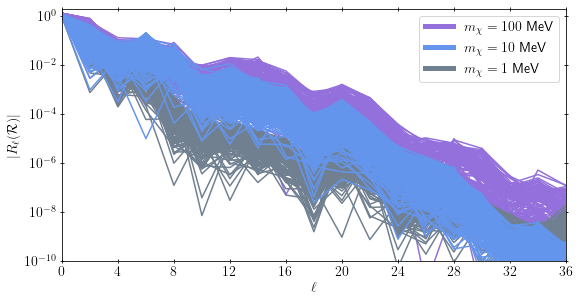

In [173]:
unisize = 3.5
fig = plt.figure(figsize=[2.0*unisize,1*unisize])
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
rm = (100, 0)
for i in range(100):
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='mediumpurple')
rm = (100, 2)
for i in range(100):
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='mediumpurple')
rm = (1, 0)
for i in range(100):
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='slategray')
rm = (1, 2)
for i in range(100):
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='slategray')
rm = (10, 0)
for i in range(100):
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='cornflowerblue')
rm = (10, 2)
for i in range(100):
    ax.plot(ells, np.abs(mu_norm[rm][i]), color='cornflowerblue')

ax.plot(ells, -np.abs(mu_norm[(100,0)][100]), color='mediumpurple', 
        label=r'$m_\chi=100$ MeV', linewidth=5)
ax.plot(ells, -np.abs(mu_norm[(10,0)][100]), color='cornflowerblue', 
        label=r'$m_\chi=10$ MeV', linewidth=5)
ax.plot(ells, -np.abs(mu_norm[(1,0)][100]), color='slategray', 
        label=r'$m_\chi=1$ MeV', linewidth=5)
ax.set_xlim([0, 36])
ax.set_ylim([1e-10, 2])
ax.set_xticks([4*j for j in range(10)])
ax.set_ylabel(r'$|R_\ell(\mathcal R)|$', fontsize=14, usetex=True)
ax.set_xlabel(r'$\ell$', fontsize=14, usetex=True)
ax.tick_params(axis='both', labelsize=14, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)



ax.legend(fontsize=14)
fig.show()

# Counterexample: Direct integration 

In [68]:
DeltaE = 4.03*eV
mX = 10*MeV
fdmn = 2
vmax = 960*km_s
qmax = 10*qBohr
def fs2_cart(qx, qy, qz):
    return fs2_nz((4/qBohr, 7/qBohr, 10/qBohr), 2, (qx,qy,qz))


def gX_cart(ux, uy, uz):
    sum_i = 0.
    for gvec in gvec_list_4:
        (c_i, uSph_i, sigma_i) = gvec
        (ux_i, uy_i, uz_i) = vsdm.sph_to_cart(uSph_i)
        du2 = (ux - ux_i)**2 + (uy - uy_i)**2 + (uz - uz_i)**2
        gaussnorm = math.pi**(-1.5) * sigma_i**(-3) * math.exp(-du2/sigma_i**2)
        sum_i += c_i * gaussnorm
    return sum_i
    

def integrandR(qXYZvXY):
    [qx, qy, qz, vx, vy] = qXYZvXY
    q = math.sqrt(qx**2 + qy**2 + qz**2)
    vz = 1/qz * (DeltaE + q**2/(2*mX) - qx*vx - qy*vy)
    if vz<-vmax or vz>vmax:
        return 0
    fdm2 = (qBohr/q)**(2*fdmn)
    gx = gX_cart(vx, vy, vz)
    fs2 = fs2_cart(qx, qy, qz)
    return fdm2 * gx * fs2 / math.sqrt(qz**2) / 5.7577e8
    

In [78]:
volumeQ3V2 = [[-qmax,qmax]]*3 + [[-vmax,vmax]]*2
integrator = vegas.Integrator(volumeQ3V2)

t0 = time.time()
init = integrator(integrandR, nitn=7, neval=1e4)
print(init.summary())
print(time.time() - t0)
result = integrator(integrandR, nitn=10, neval=1e6)
print(result.summary())
tAlt = time.time() - t0
print((result - 1)*100)
print(tAlt)


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.035(22)       0.035(22)           0.00     1.00
  2   0.53(40)        0.037(22)           1.49     0.22
  3   0.112(26)       0.068(17)           3.14     0.04
  4   0.54(12)        0.079(17)           7.60     0.00
  5   14(14)          0.079(17)           5.97     0.00
  6   1.08(23)        0.084(17)           8.60     0.00
  7   1.05(17)        0.094(17)          12.72     0.00

4.148550271987915
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   1.000(14)       1.000(14)           0.00     1.00
  2   0.9988(71)      0.9989(63)          0.00     0.96
  3   1.0066(45)      1.0040(37)          0.48     0.62
  4   0.9986(28)      1.0005(22)          0.78     0.50
  5   1.0053(23)      1.0028(16)          1.14     0.33
  6   1.0010(19)      1.0020(12)          1.03     0.40
  7   1.0010(16)      1.00165

In [79]:
volumeQ3V2 = [[-qmax,qmax]]*3 + [[-vmax,vmax]]*2
integrator = vegas.Integrator(volumeQ3V2)

t0 = time.time()
init = integrator(integrandR, nitn=7, neval=1e4)
print(init.summary())
print(time.time() - t0)
result = integrator(integrandR, nitn=10, neval=7e5)
print(result.summary())
tAlt = time.time() - t0
print((result - 1)*100)
print(tAlt)


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0090(51)      0.0090(51)          0.00     1.00
  2   240(239)        0.0090(51)          1.00     0.32
  3   0.123(42)       0.0108(51)          4.21     0.01
  4   0.322(88)       0.0118(51)          6.94     0.00
  5   1.26(28)        0.0122(51)         10.36     0.00
  6   0.787(57)       0.0183(50)         44.98     0.00
  7   1.09(18)        0.0191(50)         43.18     0.00

3.9414730072021484
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   1.012(34)       1.012(34)           0.00     1.00
  2   0.9697(77)      0.9717(75)          1.45     0.23
  3   0.9828(78)      0.9770(54)          1.24     0.29
  4   1.0061(53)      0.9919(38)          5.74     0.00
  5   0.9976(33)      0.9952(25)          4.63     0.00
  6   1.0021(25)      0.9986(18)          4.48     0.00
  7   1.0045(21)      1.0010

In [80]:
volumeQ3V2 = [[-qmax,qmax]]*3 + [[-vmax,vmax]]*2
integrator = vegas.Integrator(volumeQ3V2)

t0 = time.time()
init = integrator(integrandR, nitn=7, neval=1e4)
print(init.summary())
print(time.time() - t0)
result = integrator(integrandR, nitn=10, neval=4e5)
print(result.summary())
tAlt = time.time() - t0
print((result - 1)*100)
print(tAlt)


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.020(12)       0.020(12)           0.00     1.00
  2   0.160(82)       0.023(12)           2.86     0.09
  3   0.29(16)        0.024(12)           2.87     0.06
  4   0.40(14)        0.027(12)           4.20     0.01
  5   0.84(19)        0.030(12)           7.86     0.00
  6   1.25(25)        0.032(11)          10.86     0.00
  7   0.98(14)        0.039(11)          16.87     0.00

4.307883024215698
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.978(19)       0.978(19)           0.00     1.00
  2   0.977(13)       0.978(11)           0.00     0.97
  3   0.997(10)       0.9877(74)          0.88     0.41
  4   1.0074(80)      0.9967(54)          1.68     0.17
  5   0.9997(35)      0.9988(29)          1.32     0.26
  6   1.0016(28)      1.0003(20)          1.15     0.33
  7   1.0002(25)      1.0003(

In [81]:
volumeQ3V2 = [[-qmax,qmax]]*3 + [[-vmax,vmax]]*2
integrator = vegas.Integrator(volumeQ3V2)

t0 = time.time()
init = integrator(integrandR, nitn=7, neval=1e4)
print(init.summary())
print(time.time() - t0)
result = integrator(integrandR, nitn=10, neval=2e6)
print(result.summary())
tAlt = time.time() - t0
print((result - 1)*100)
print(tAlt)


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0015(13)      0.0015(13)          0.00     1.00
  2   0.30(19)        0.0015(13)          2.36     0.12
  3   1.27(76)        0.0015(13)          2.57     0.08
  4   1.27(51)        0.0016(13)          3.80     0.01
  5   0.98(15)        0.0016(13)         14.18     0.00
  6   0.93(10)        0.0018(13)         28.11     0.00
  7   0.927(42)       0.0026(13)        104.01     0.00

4.468539714813232
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.993(14)       0.993(14)           0.00     1.00
  2   0.9949(72)      0.9946(64)          0.01     0.92
  3   1.013(15)       0.9973(59)          0.60     0.55
  4   0.9978(25)      0.9977(23)          0.40     0.75
  5   0.9986(16)      0.9983(13)          0.33     0.86
  6   1.0008(12)      0.99965(88)         0.65     0.66
  7   1.0001(12)      0.99982

In [85]:
volumeQ3V2 = [[-qmax,qmax]]*3 + [[-vmax,vmax]]*2
integrator = vegas.Integrator(volumeQ3V2)

t0 = time.time()
init = integrator(integrandR, nitn=7, neval=1e3)
print(init.summary())
print(time.time() - t0)
result = integrator(integrandR, nitn=10, neval=7e4)
print(result.summary())
tAlt = time.time() - t0
print((result - 1)*100)
print(tAlt)


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.000076(53)    0.000076(53)        0.00     1.00
  2   0.238(78)       0.000076(53)        9.40     0.00
  3   1.03(54)        0.000076(53)        6.55     0.00
  4   3.2(2.5)        0.000076(53)        4.91     0.00
  5   0.509(84)       0.000077(53)       12.94     0.00
  6   0.90(16)        0.000077(53)       16.68     0.00
  7   0.81(11)        0.000077(53)       22.33     0.00

0.4394807815551758
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.970(49)       0.970(49)           0.00     1.00
  2   1.015(39)       0.997(30)           0.55     0.46
  3   1.006(29)       1.002(21)           0.29     0.75
  4   0.994(13)       0.996(11)           0.23     0.88
  5   0.9819(94)      0.9880(71)          0.42     0.80
  6   1.005(12)       0.9926(61)          0.65     0.66
  7   1.0042(92)      0.9961